<a href="https://colab.research.google.com/github/dong-uk-kim97/kaggle_study/blob/main/Titanic_Top_4_with_ensemble_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Top 4% with ensemble modeling

Yassine Ghouzam, PhD

13/07/2017

- 1 Intorduction
- 2 load and check data
  - 2.1 load data
  - 2.2 Outlier detection
  - 2.3 joining train and test set
  - 2.4 check for null and missing values
- 3 Feature analysis
  - 3.1 Numerical values
  - 3.2 Categorical values
- 4 Filling missing Values
  - 4.1 Age
- 5 Feature engineering
  - 5.1 Name/Title
  - 5.2 Family Size
  - 5.3 Cabin
  - 5.4 Ticket
- 6 Modeling
  - 6.1 Simple modeling
    - 6.1.1 Cross validate models
    - 6.1.2 Hyperparameter tuning for best models
    - 6.1.3 Plot learning curves
    - 6.1.4 Feature importance of tree based classifiers 
  - 6.2 Ensemble modeling 
    - 6.2.1 Combining models
  - 6.3 Prediction
    - 6.3.1 Predict and Submit results

# 1. Introduction

This is my first kernel at Kaggle. I choosed the Titanic competition which is a good way to introduce feature engineering and ensemble modeling. Firstly, I will display some feature analyses then ill focus on the feature engineering. Last part concerns modeling and predicting the survival on the Titanic using an voting procedure.

The script follows three main parts:
  - Feature analysis
  - Feature engineering
  - Modeling

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

# 2. Load and check data

## 2.1 Load data

In [2]:
# Load data
##### Load train and Test set

train = pd.read_csv('/content/drive/MyDrive/dietanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dietanic/test.csv')
IDtest = test['PassengerId']

## 2.2 Outlier detection

In [3]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

특이치는 예측(특히 회귀 문제의 경우)에 큰 영향을 미칠 수 있으므로 특이치를 관리하기로 선택했습니다.

분포 값(IQR)의 1분위와 3분위 사이에 구성된 사분위간 범위를 정의하는 유리에를 검출하기 위해 Tukey 방법(Tukey JW., 1977)을 사용했습니다. 특이치는 피쳐 값이 외부에 있는 행(IQR + - 특이치 단계)입니다.

수치 특성(연령, SibSp, 검색 및 요금)에서 특이치를 감지하기로 결정했다. 그런 다음 특이치를 최소 두 개의 아웃레이드 숫자 값이 있는 행으로 간주했습니다.

In [4]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


우리는 10로 분리된 것을 감지한다.2889그리고 342종의 승객이 높은 항공권 요금을 가지고 있다.

7 다른 사람들 SibSP의 매우 높은 가치가 있다.

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## 2.3 joining train and test set

In [6]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

나는 단정적인 변환(특징 공학 참고 항목)중에 형상의 동일한 번호를 얻기 위해 train과 test 데이터 셋을 합친다.

## 2.4 check for null and missing values

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age and Cabin features have an important part of missing values.

**Survived missing values correspond to the join testing dataset (Survived column doesn't exist in test set and has been replace by NaN values when concatenating the train and test set)**

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis

## 3.1 Numerical values

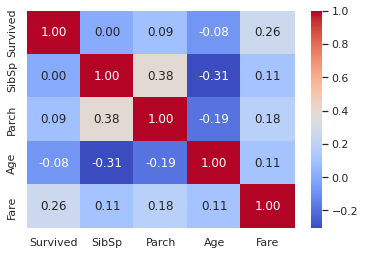

In [12]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

오직 Fare 특징만 생존 가능성과 뜻 깊은 상관이 있는 것 같다.

다른 기능이 유용하지 않다는 뜻은 아닙니다. 이러한 특징의 하위 집단은 생존과 상관관계가 있을 수 있다. 이를 확인하려면 이러한 기능을 자세히 살펴봐야 합니다.

## SibSP

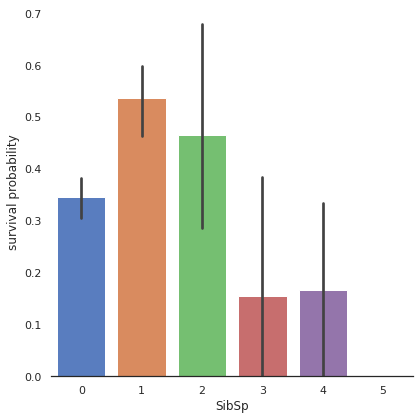

In [13]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

형제자매/배우자가 많은 승객들은 살아남을 기회가 적은 것 같다.

싱글 승객(0 SibSP) 또는 다른 2명(SibSP 1 또는 2)이 생존할 가능성이 더 높습니다.

이러한 관찰은 매우 흥미롭습니다. 이러한 범주를 설명하는 새로운 기능을 고려할 수 있습니다(Feature Engineering 참조).


## Parch

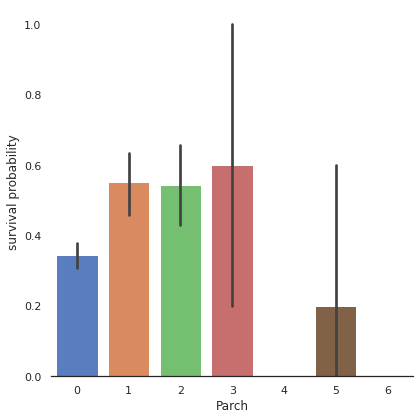

In [14]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

소가족은 단일가족(Parch 0), 중간가족(Parch 3, 4), 대가족(Parch 5, 6)보다 생존 기회가 더 많다.

부모/자녀가 3명인 승객의 생존에 중요한 표준 편차가 있으므로 주의하십시오.

## Age

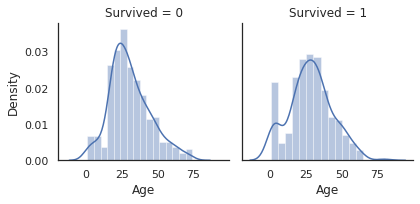

In [15]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

연령 분포는 꼬리 분포, 아마도 가우스 분포인 것 같다.

우리는 생존한 하위 모집단과 생존하지 않은 하위 모집단에서 연령 분포가 같지 않다는 것을 알아차린다. 실제로 살아남은 젊은 승객에 해당하는 봉우리가 있다. 우리는 또한 60-80세 사이의 승객들이 덜 살아남았다는 것을 볼 수 있다.

따라서, "나이"가 "생존"과 상관관계가 없다고 하더라도, 우리는 생존할 가능성이 다소 있는 승객들의 연령 범주가 있다는 것을 알 수 있다.

아주 어린 승객들이 생존할 기회가 더 많은 것 같다.

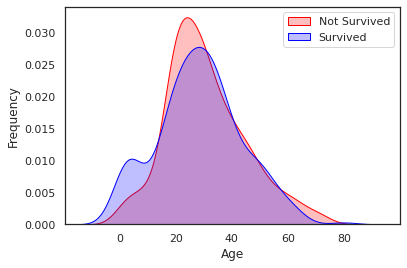

In [16]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

우리가 두 밀도를 중첩할 때, 우리는 아기들과 매우 어린 아이들에 대응하는 피크(0과 5 사이)를 분명히 볼 수 있다.

## Fare

In [17]:
dataset["Fare"].isnull().sum()

1

In [18]:
# Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

결측값이 하나 있기 때문에 예측에 중요한 영향을 미치지 않는 중위수 값으로 채우기로 했습니다.

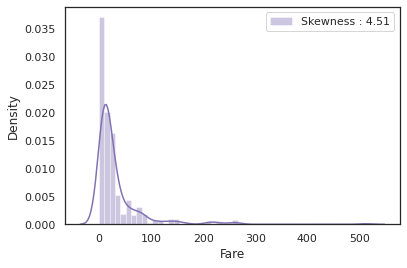

In [19]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

우리가 알 수 있듯이, 요금 분배는 매우 치우쳐 있다. 따라서 크기가 조정되더라도 모형에서 과중량이 매우 높을 수 있습니다.

이 경우 로그 함수로 변환하여 이러한 왜곡을 줄이는 것이 좋습니다.

In [20]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

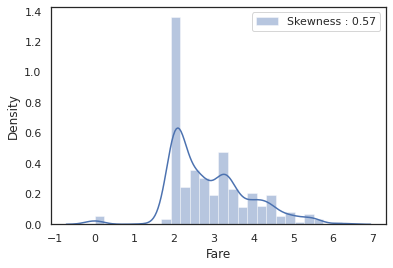

In [21]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

로그 변환 후 왜도가 뚜렷하게 감소됨을 확인할 수 있다.

## 3.2 Categorical values

sex

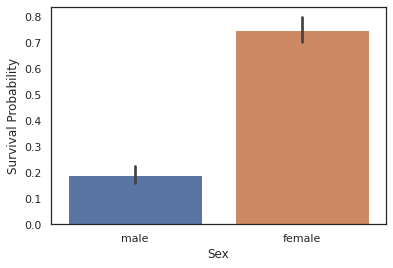

In [22]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [23]:
train[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남성이 여성보다 생존 가능성이 적다는 것은 명백하다.

성별은 생존을 예측하는 데 중요한 역할을 할 수 있습니다

타이타닉 영화 (1997년)를 본 사람들에게, 나는 우리 모두가 대피하는 동안 이 문장을 기억할 것이라고 확신한다: "여성과 아이들이 먼저".

Pclass

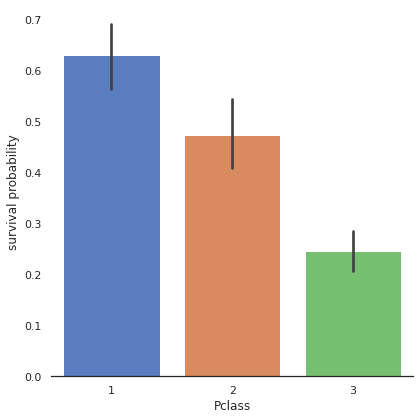

In [24]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

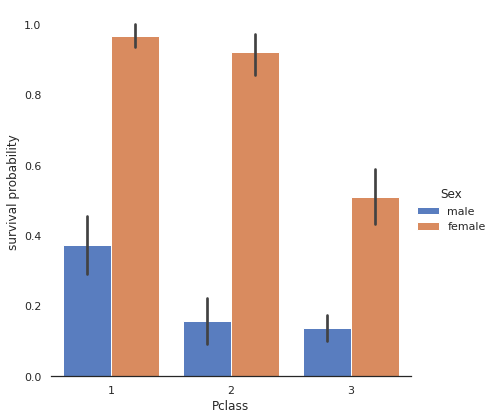

In [25]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

3개의 클래스에서 승객 생존율이 동일하지 않습니다. 일등석 승객들은 이등석 승객들과 삼등석 승객들보다 생존할 기회가 더 많다.

우리가 남성과 여성 승객 모두를 볼 때 이 추세는 보존된다.

Embarked

In [26]:
dataset["Embarked"].isnull().sum()

2

In [27]:
# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

우리는 두명의 사라진 가치를 갖는다면, 나는"Embarked"(S)의 가장fequent 값으로 그런 일자리를 채우기로 결정했다.

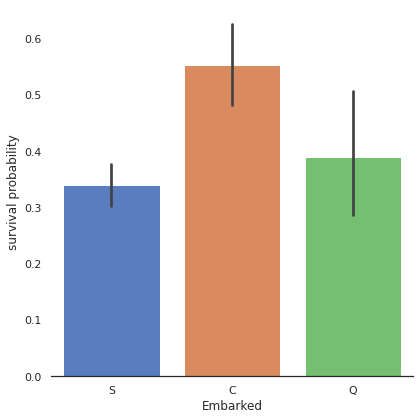

In [28]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

셰르부르(C)에서 오는 승객들이 생존할 기회가 더 많아 보인다.

내 가설은 일등석 승객의 비율이 퀸스타운(Q), 사우샘프턴(S)보다 셰르부르에서 온 승객의 비율이 더 높다는 것이다.

P클래스 분배와 출항항구를 비교해서 살펴보겠습니다.

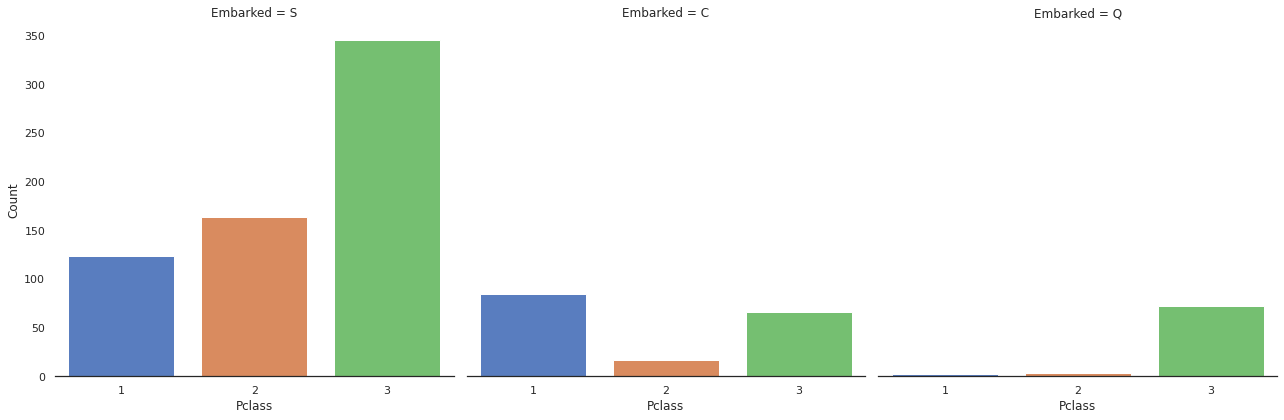

In [29]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

실제로 3등석은 사우샘프턴(S)과 퀸스타운(Q)에서 오는 승객들이 가장 많은 반면 셰르부르 승객들은 생존율이 가장 높은 1등석들이 대부분이다.

이 시점에서, 나는 왜 일등석이 더 높은 생존율을 가지고 있는지 설명할 수 없다. 내 가설은 일등석 승객들이 그들의 영향 때문에 대피하는 동안 우선 순위를 매겼다는 것이다.

# 4. Filling missing Values

4.1 Age

보시다시피, 연령 열은 전체 데이터 세트에 256개의 결측값을 포함합니다.

생존 가능성이 더 많은 하위 집단(예를 들어 어린이)이 있으므로 연령 특징을 유지하고 결측값을 귀속시키는 것이 바람직하다.

이 문제를 해결하기 위해 나이(성별, Parch, Pclass, SibSP)와 가장 상관관계가 있는 특징을 살펴보았다.

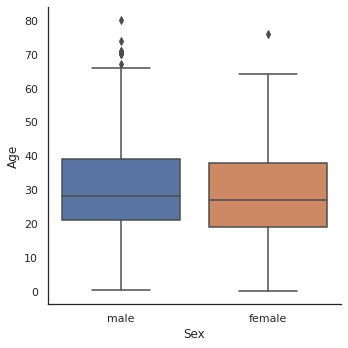

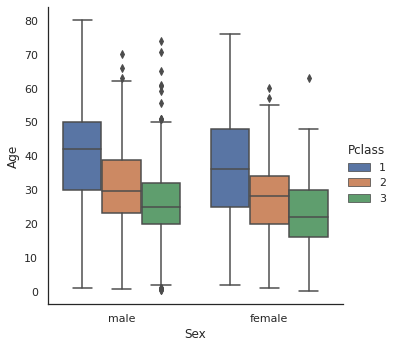

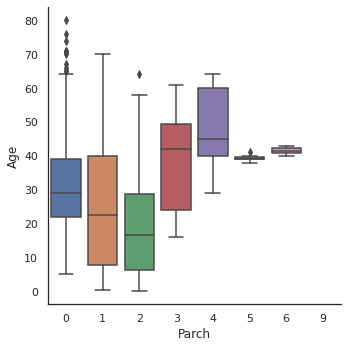

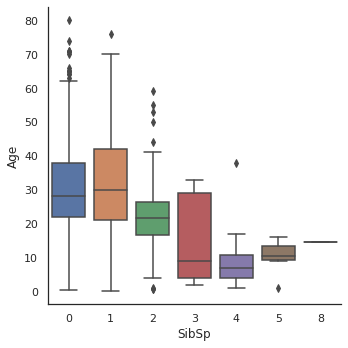

In [30]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

연령 분포는 남성과 여성의 하위 모집단에서 동일한 것으로 나타나므로 성별은 나이를 예측하는 데 도움이 되지 않습니다.

그러나 1등석 승객은 3등석 승객보다 나이가 많은 2등석 승객보다 나이가 많다.

게다가, 승객이 부모/자녀를 많이 가질수록 그는 나이가 들고 더 많은 형제/배우자를 가질수록 그는 더 젊어진다.

In [31]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

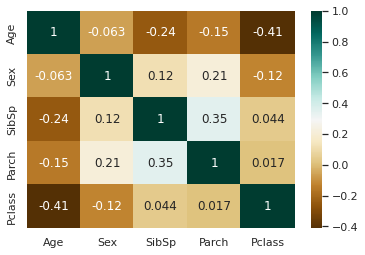

In [32]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

상관관계 히트맵은 Parch를 제외한 요인 그림 관측치를 확인합니다. 나이는 성별과 상관관계가 없지만 Pclass, Parch, SibSp와 부정적으로 상관관계가 있다.

Parch의 기능에 있는 나이 그림에서 나이는 부모/자녀의 수와 함께 성장하고 있습니다. 그러나 일반적인 상관관계는 부정적이다.

그래서 나는 사라진 나이를 돌리기 위해 SibSP, Parch, Pclass를 사용하기로 했다.

Pclass, Parch, SibSp에 따라 비슷한 행의 중위연령으로 Age를 채우는 전략이다.

In [33]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

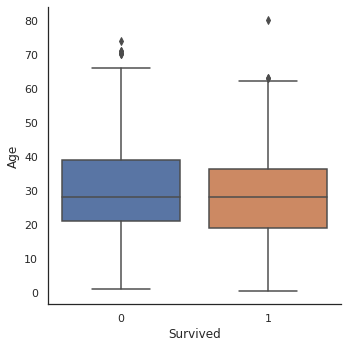

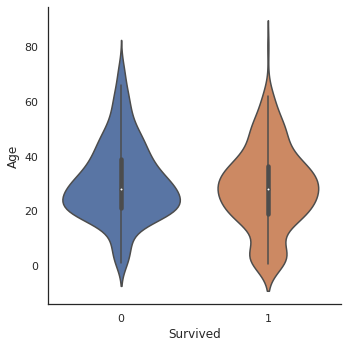

In [34]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

생존 인구와 비생존 인구 연령의 중위수 값 사이에 차이가 없습니다.

하지만 살아남은 승객들의 바이올린 플롯에서, 우리는 여전히 매우 어린 승객들이 더 높은 생존율을 가지고 있다는 것을 알아차립니다.

# 5. Feature engineering

5.1 Name/Title

In [35]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

이름 기능에는 승객의 직함에 대한 정보가 포함되어 있습니다.

대피 중에는 고유 명칭의 승객이 선호될 수 있으므로, 모델에 추가하는 것이 흥미롭다.

In [36]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

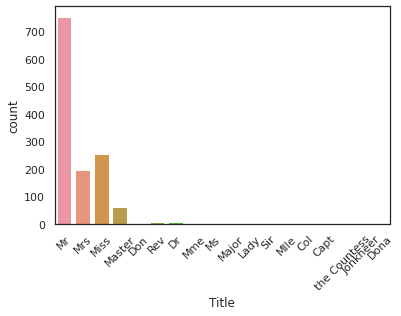

In [37]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

데이터 세트에는 17개의 제목이 있으며, 대부분은 매우 희귀하며 4가지 범주로 그룹화할 수 있다.

In [38]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

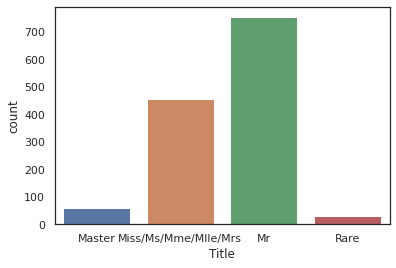

In [39]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

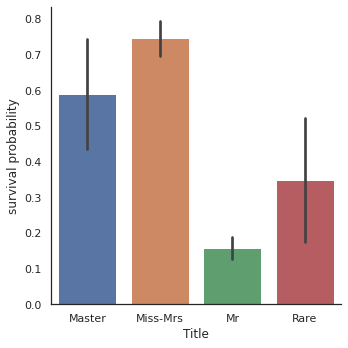

In [40]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

"여성과 아이들이 먼저"

희귀한 직함을 가진 승객들이 생존할 수 있는 기회가 더 많다는 것에 주목하는 것은 흥미롭다.

In [41]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

5.2 Family size

우리는 대가족이 대피하는 동안 그들의 자매/형제/부모를 찾으면서 대피하는 데 더 많은 어려움을 겪을 것이라고 상상할 수 있다. 그래서 저는 SibSp, Parch, 그리고 1(승객 포함)을 합한 "Fiz"(패밀리 크기) 기능을 만들기로 했다.

In [42]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

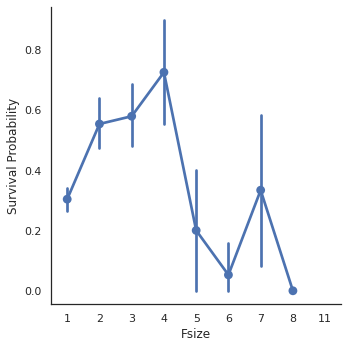

In [43]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

그 가족은 크기 중요한 역할을 할 생존 확률 큰 가족들에게 최악의 상황이 있는 것 같다.

게다가, 나는 가족 크기의 4개를 만들기로 결정했다.

In [44]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

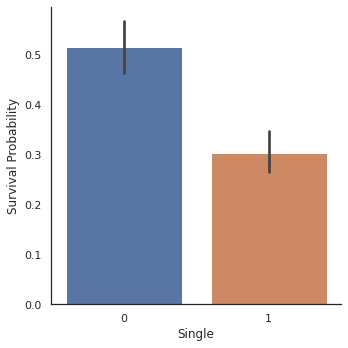

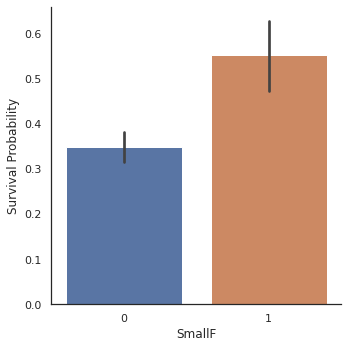

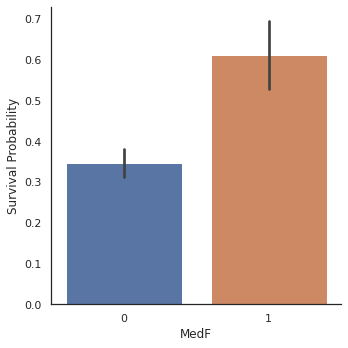

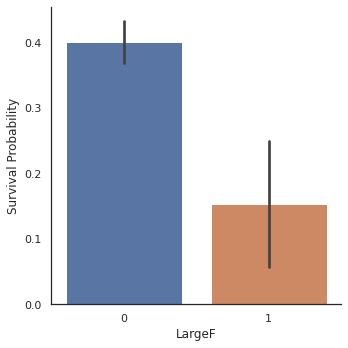

In [45]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

가족 크기 범주의 요인 그림을 보면 중소형 가족이 1인승 및 대가족보다 생존 가능성이 더 많다는 것을 알 수 있습니다.

In [46]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [47]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


At this stage, we have 22 features.

5.3 Cabin

In [48]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [49]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [50]:
dataset["Cabin"].isnull().sum()

1007

객실 feature 열에는 292개의 값과 1007개의 결측값이 포함된다.
저는 객실이 없는 승객은 객실 번호 대신 결측값이 표시되어 있다고 생각했다.

In [51]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [52]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in dataset["Cabin"])

이후는 승객석의 타이타닉에서 가장 가능성 있는 위치를 나타내는 선실의 첫번째 편지, 나는 이 정보를 유지할 choosed, 데스크를 나타낸다.

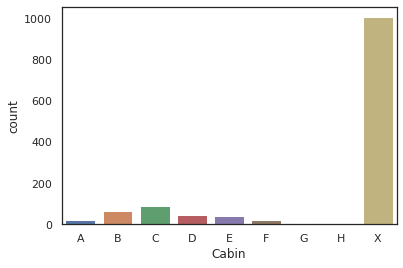

In [53]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','H','X'])

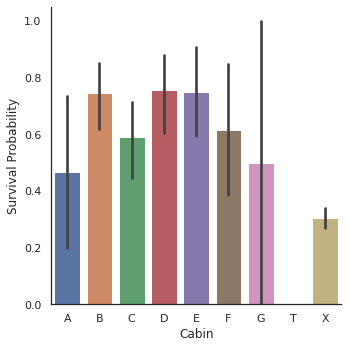

In [54]:
g = sns.factorplot(y="Survived", x='Cabin', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

객실을 가지고 있는 승객의 수가 적기 때문에 생존 확률은 중요한 표준 편차를 가지고 있고 우리는 다른 책상에 있는 승객의 생존 확률을 구별할 수 없습니다.

그러나 우리는 일반적으로 객실을 가진 승객들이 (X)가 없는 승객들보다 생존할 기회가 더 많다는 것을 알 수 있습니다.

특히 객실 B, C, D, E 및 F에 해당됩니다.

In [55]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix='Cabin')

5.4 Ticket

In [56]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

그것은 같은 접두사를 공유하는 티켓이 함께 배치된 객실을 위해 예약될 수 있다는 것을 의미할 수 있다. 따라서 선내 선실의 실제 배치로 이어질 수 있습니다.

같은 접두사를 가진 티켓은 비슷한 등급과 생존율을 가질 수 있다.

그래서 티켓 기능 열을 티켓 접두사로 바꾸기로 했습니다. 그게 더 유익할 수도 있어

In [57]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
  #Take prefix
  else:
    Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [58]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [59]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [60]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [61]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6.MODELING

In [62]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"], axis =1 , inplace=True)

In [63]:
## Separate train features and label

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels=["Survived"], axis=1)

## 6.1 Simple modeling

### 6.1.1 Cross validate models

10개의 인기 분류기를 비교하고 계층화된 kfold 교차 검증 절차를 통해 각각의 평균 정확도를 평가한다.
- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosing
- Multiple layer perceptron (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [64]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

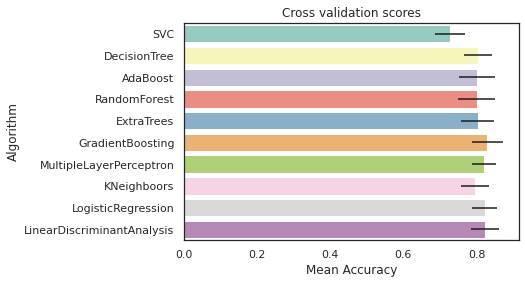

In [65]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

나는 앙상블 모델에 대한 SVC, AdaBoost, RandomForest, ExtraTrees고 GradientBoosting classifiers을 선택하기로 결정했다.

6.1.2 Hyperparameter tuning for best models

나는 AdaBoost, ExtraTree, RandomForest, GradientBoost 및 SVC 분류기에 대한 그리드 검색 최적화를 수행했다.

나는 CPU가 4개이기 때문에 "n_jobs" 파라미터를 4로 설정했다. 계산 시간이 확실히 단축됩니다.

하지만 조심해요, 이 단계는 오래 걸릴 수 있어요, 4 CPU로 총 15분 걸렸어요.

In [66]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [67]:
gsadaDTC.best_score_

0.8275536261491316

In [68]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8320224719101124

In [69]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.832035240040858

In [70]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8297242083758938

In [71]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

6.1.3 Plot learning curves

학습 곡선은 훈련 세트에 대한 과적합 효과와 정확도에 대한 훈련 크기의 효과를 볼 수 있는 좋은 방법이다.

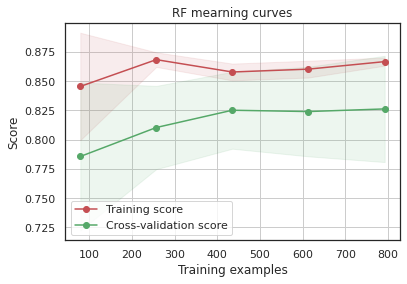

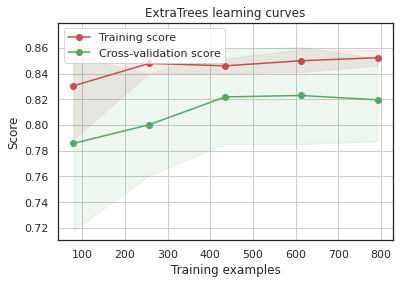

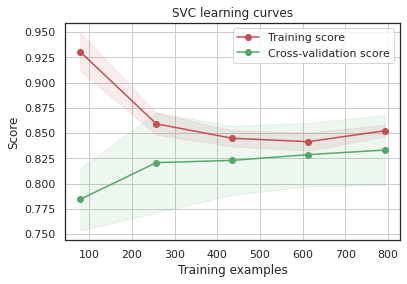

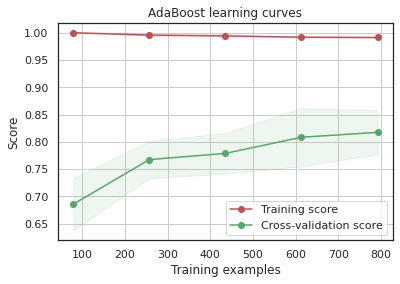

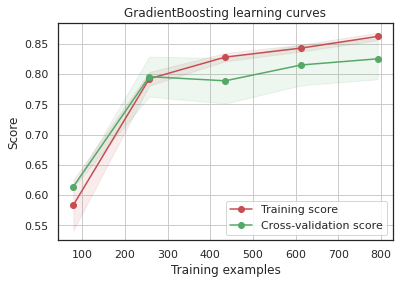

In [72]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

GradientBoosting 및 Adboost 분류기는 훈련 세트를 과적합시키는 경향이 있다. 교차 검증 곡선이 증가함에 따라 GradientBoost 및 Adboost는 더 많은 훈련 예제를 통해 더 나은 성능을 발휘할 수 있다.

SVC와 ExtraTree 분류기는 훈련과 교차 검증 곡선이 가까이 있기 때문에 예측을 더 잘 일반화하는 것으로 보인다.

6.1.4 Feature importance of tree based classifiers

승객만 생존 예측을 위한 가장 유익한 특징을 보고, 나는 4나무 기준으로 classifiers의 특징 중요성을 보여 주었다.

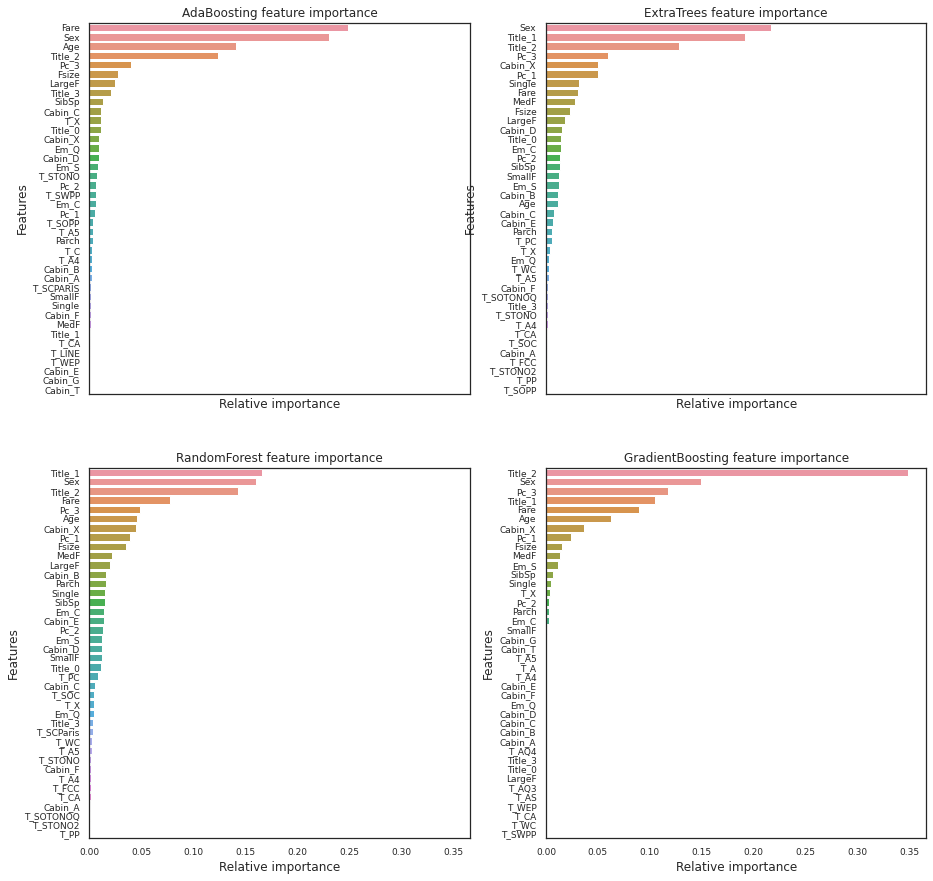

In [73]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

4개의 트리 기반 분류기(Adaboost, Extra Tree, Random Forest 및 Gradient Boost)에 대한 기능 중요도를 표시합니다.

우리는 네 가지 분류기가 상대적 중요도에 따라 다른 상위 특징을 가지고 있다는 것에 주목한다. 이것은 그들의 예측이 같은 특징을 기반으로 하지 않는다는 것을 의미한다. 그럼에도 불구하고 이들은 '요금', '제목_2', '나이', '섹스'와 같은 분류를 위한 몇 가지 공통적인 중요한 특징을 공유한다.

Mrs/Mle/Mme/Miss/Ms 범주를 나타내는 Title_2는 Sex와 높은 상관 관계를 가집니다.

다음과 같이 말할 수 있습니다.

- Pc_1, Pc_2, Pc_3 및 요금은 승객의 일반적인 사회적 지위를 나타냅니다.

- Sex and Title_2(Mrs/Mlle/Mme/Miss/Ms)와 Title_3(Mr)은 성별을 나타냅니다.

- 나이와 제목_1(주)은 승객의 나이를 나타냅니다.

- Fsize, LargeF, MedF, Single은 승객 가족의 크기를 나타냅니다.

**이 4가지 분류기의 특징적 중요성에 따라 생존 예측은 보트 내 위치보다 연령, 성별, 가족 규모, 승객의 사회적 지위 등과 더 관련이 있는 것으로 보인다.**

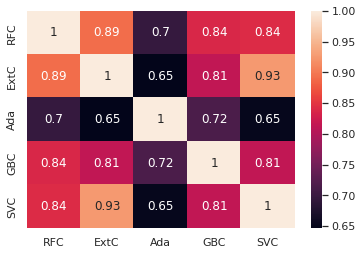

In [74]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

이 예측은 Adaboost를 다른 분류기와 비교할 때를 제외하고는 5개의 분류기에 대해 상당히 유사한 것으로 보인다.

5개의 분류기는 다소 동일한 예측을 제공하지만 약간의 차이가 있습니다. 5가지 분류자 예측 간의 이러한 차이는 앙상블 투표를 고려하기에 충분하다.

## 6.2 Ensemble modeling

6.2.1 Combining models
나는 5개의 분류기에서 나오는 예측을 결합하기 위해 투표 분류기를 선택했다.

나는 각 투표의 확률을 고려하기 위해 "부드러운" 주장을 투표 매개변수에 전달하는 것을 선호했다.


In [75]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

## 6.3 Prediction

6.3.1 Predict and Submit results

In [76]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)

이 노트북이 도움이 되셨거나 마음에 드셨다면, 몇 가지 업보트를 해주시면 대단히 감사하겠습니다. 그렇게 하면 동기부여가 될 것입니다. :)

# 출처

https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook